In [1]:
from __future__ import division
import math
import numpy as np
import torch
from torchvision.models.alexnet import alexnet
from torchvision.models.vgg import vgg16, vgg19
from torchvision.models.resnet import resnet18, resnet50
from torchvision.models.densenet import densenet121
from torchvision.models.inception import Inception3 as inception3
from torchvision import transforms
from PIL import Image
import sys
import time
import random
import cv2
import gc

sys.path.append('../../../code')

from python.commons import full_inference_e2e_with_model, inc_inference_e2e_with_model
from python.vgg16 import VGG16
from python.resnet18 import ResNet18
from python.inception3 import Inception3

from torch.autograd import Variable

import matplotlib.pyplot as plt
from plot_commons import get_ivm_patch_coordinates, calculate_ivm_flops, calculate_flops, mean_confidence_interval

random.seed(45)
np.random.seed(45)

torch.set_num_threads(8)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
def inc_inference_selected_with_model(inc_model, file_path, patch_size, stride, patch_positions, batch_size=64, beta=1.0,
                           x0=0, y0=0, image_size=224, x_size=224, y_size=224, gpu=True, version='v1',
                           n_labels=1000, weights_data=None, loader=None, c=0.0):

    if loader == None:
        loader = transforms.Compose([transforms.Resize([image_size, image_size]), transforms.ToTensor()])
    orig_image = Image.open(file_path).convert('RGB')
    orig_image = loader(orig_image).unsqueeze(0)

    if gpu:
        orig_image = orig_image.cuda()

    image_patches = torch.FloatTensor(3, patch_size, patch_size).fill_(c).repeat(batch_size, 1, 1, 1)
        
    x_output_width = int(math.ceil((x_size*1.0 - patch_size) / stride))
    y_output_width = int(math.ceil((y_size*1.0 - patch_size) / stride))

    total_number = x_output_width * y_output_width
    logit_values = np.zeros((x_output_width, y_output_width), dtype=np.float32)
    
    num_batches = int(math.ceil(len(patch_positions) * 1.0 / batch_size))
    
    if gpu:
        inc_model = inc_model.cuda()
        
    temp = inc_model.forward_materialized(orig_image).cpu().data.numpy()
    logit_index = np.argmax(temp)
    prob = np.max(temp)
 
    locations = torch.zeros([batch_size, 2], dtype=torch.int32)
    
    for i in range(num_batches):
        for j in range(batch_size):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break

            x, y = patch_positions[index]
            x = x*stride + x0
            y = y*stride + y0
            x,y = int(x), int(y)
            
            locations[j, 0] = x
            locations[j, 1] = y

        if version == 'v1':
            logits = inc_model.forward_gpu(image_patches, locations, p_height=patch_size, p_width=patch_size)
        else:
            logits = inc_model.forward_pytorch(image_patches, locations, p_height=patch_size, p_width=patch_size)
            
        logits = logits.cpu().data.numpy()[:, logit_index].flatten().tolist()

        for logit, j in zip(logits, range(batch_size)):
            index = j * num_batches + i
            if index >= len(patch_positions):
                break
            x, y = patch_positions[index]
            logit_values[x, y] = logit

    del inc_model
    gc.collect()

    return logit_values, prob, logit_index



def adaptive_drilldown_with_model(model1, model2, file_path, patch_size, s2, percentile, speedup, batch_size=128, image_size=224,
                       x_size=224, y_size=224, beta=1.0, gpu=True, version='v1',
                       n_labels=1000, weights_data=None, loader=None, c=0.0):

    final_out_width = int(math.ceil((image_size*1.0-patch_size)/s2))
    s1 = round(math.sqrt(speedup/(1-percentile*speedup)) * s2)
    percentile *= 100 

    #checking for interested regions
    temp1, prob, logit_index = inc_inference_e2e_with_model(model1, file_path, patch_size, s1,
                                    batch_size=batch_size, beta=beta, image_size=image_size, x_size=x_size,
                              y_size=y_size, gpu=gpu, version=version, weights_data=weights_data, loader=loader, c=c)

    temp1 = cv2.resize(temp1, (final_out_width, final_out_width), interpolation=cv2.INTER_LINEAR)
    threshold = np.percentile(temp1, percentile)
    temp1 = np.where(temp1 <= threshold, 0, temp1)
    idx = np.argwhere(temp1 <= threshold)
    
    #drilldown into interested regions
    temp2, prob, logit_index = inc_inference_selected_with_model(model2, file_path, patch_size, s2, idx.tolist(),
                                    batch_size=batch_size, beta=beta, image_size=image_size,
                              x_size=image_size, y_size=image_size, gpu=gpu, version=version,
                            weights_data=weights_data, loader=loader, c=c)

    
    
    return np.add(temp1, temp2), prob, logit_index

def get_r_drill_down_speedup(datset):
    if dataset == "oct":
        return 0.1, 5
    elif dataset == "chest_xray":
        return 0.4, 2
    elif dataset == "imagenet":
        return 0.25, 3
    
def get_tau(model, dataset):
    if model == "VGG16":
        return 0.5
    elif model == "ResNet18":
        if dataset == "chest_xray":
            return 0.8
        else:
            return 0.7
    elif model == "Inception3":
        if dataset == "chest_xray":
            return 0.8
        else:
            return 0.9

In [7]:
colors = ['blue', 'orange', 'green', 'red']

In [ ]:
models = ["VGG16", "ResNet18", "Inception3"]
patch_size = 16
S2 = 4
c = 0.0
runs = 3

datasets = ["oct", "chest_xray", "imagenet"]
dataset_names = {"oct": "OCT", "chest_xray": "Chest X-Ray", "imagenet": "ImageNet"}
image_file_path = '../../../code/python/dog_resized.jpg'

log_file = open('5_1_CPU.log', 'a')
log_file.write("=========================================================\n")
log_file.flush()
    
fig = plt.figure(figsize=(12, 2.5))    
for idx, dataset in enumerate(datasets):
    ax = plt.subplot(1, 3, idx+1)
    
    full_inf_mean = []
    full_inf_ci = []
    ivm_exact_mean = []
    ivm_exact_ci = []
    ivm_approx_mean = []
    ivm_approx_ci = []
           
    for model in models:

        if model == "VGG16":
            ivm_model = VGG16
            image_size = 224
        elif model == "ResNet18":
            ivm_model = ResNet18
            image_size = 224
        elif model == "Inception3":
            ivm_model = Inception3
            image_size = 299

        tau = get_tau(model, dataset)

        temp_runs = []
#         cnn_model = ivm_model(gpu=False).eval()
#         for count in range(runs):

#             torch.cuda.synchronize()
#             prev_time = time.time()
#             with torch.no_grad():
#                 x, prob, logit_index = full_inference_e2e_with_model(cnn_model, image_file_path, patch_size, S2,
#                                        batch_size=16, gpu=False, image_size=image_size, x_size=image_size,
#                                        y_size=image_size, c=c)

#             torch.cuda.synchronize()
#             full_inference_time = time.time() - prev_time
#             log_file.write(",".join([str(x) for x in [dataset, model, count, "full-inf", full_inference_time]])+"\n")
#             log_file.flush()
#             temp_runs.append(full_inference_time)

#         del cnn_model
#         gc.collect()
#         m, ci = mean_confidence_interval(temp_runs)
#         full_inf_mean.append(m)
#         full_inf_ci.append(ci)


#         temp_runs = []
#         cnn_model = ivm_model(gpu=False).eval()
#         for count in range(runs):

#             torch.cuda.synchronize()    
#             prev_time = time.time()
#             with torch.no_grad():
#                 x, prob, logit_index = inc_inference_e2e_with_model(cnn_model, image_file_path, patch_size, S2,
#                                       batch_size=16, beta=1.0, gpu=False, version='v2',
#                                      image_size=image_size, x_size=image_size, y_size=image_size, c=c)

#             torch.cuda.synchronize()
#             inc_inference_time = time.time() - prev_time
#             log_file.write(",".join([str(x) for x in [dataset, model, count, "inc-inf", inc_inference_time]])+"\n")
#             log_file.flush()            
#             temp_runs.append(inc_inference_time)

#         del cnn_model
#         gc.collect()
#         m, ci = mean_confidence_interval(temp_runs)
#         ivm_exact_mean.append(m)
#         ivm_exact_ci.append(ci)


        temp_runs = []
        cnn_model1 = ivm_model(gpu=False, beta=tau).eval()
        cnn_model2 = ivm_model(gpu=False, beta=tau).eval()
        r_drill, speedup = get_r_drill_down_speedup(dataset)
        for count in range(runs):

            torch.cuda.synchronize()    
            prev_time = time.time()
            with torch.no_grad():
                x, prob, logit_index = adaptive_drilldown_with_model(cnn_model1, cnn_model2, image_file_path, patch_size, S2, r_drill, speedup,
                                    batch_size=16, beta=tau, gpu=False, version='v2',
                                    image_size=image_size, x_size=image_size, y_size=image_size,
                                    c=c)

            torch.cuda.synchronize()
            ada_time = time.time() - prev_time
            log_file.write(",".join([str(x) for x in [dataset, model, count, "inc-inf-approx", ada_time]])+"\n")
            log_file.flush()            
            temp_runs.append(ada_time)

        del cnn_model1
        del cnn_model2
        gc.collect()
        m, ci = mean_confidence_interval(temp_runs)
        ivm_approx_mean.append(m)
        ivm_approx_ci.append(ci)


#     pos = [0.8, 2., 3.2]
#     width = 0.2

#     l1 = plt.bar(pos, full_inf_mean, width, color=colors[0], hatch=3*'-',
#                  yerr=full_inf_ci, ecolor='black', alpha=0.8) 
#     l3 = plt.bar([p + width for p in pos], ivm_exact_mean, width, color=colors[2], hatch=3*'x',
#              yerr=ivm_exact_ci, ecolor='black', alpha=0.8)
#     l4 = plt.bar([p + 2*width for p in pos], ivm_approx_mean, width, color=colors[3], hatch=3*'*',
#              yerr=ivm_approx_ci, ecolor='black', alpha=0.8)
    
#     #ax.set_ylabel('Run Time (s)')
    
#     ax.set_xticks([p + width for p in pos])
#     ax.set_title(dataset_names[dataset]+"/CPU")
#     ax.set_xticklabels(models)
#     plt.xlim(min(pos)-width, max(pos)+width*3)
#     plt.grid()
        
   

# lgd = fig.legend((l1, l3, l4), ('Naive', 'Krypton-Exact', 'Krypton-Approx.'), loc=(0.25, -0.01), ncol=3, frameon=False)

# plt.savefig('../images/5_1_CPU.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')   

# plt.show()

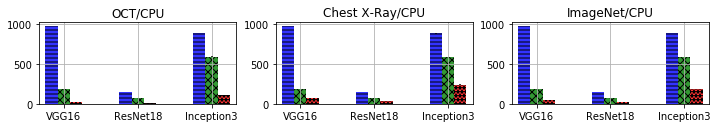

In [16]:
models = ["VGG16", "ResNet18", "Inception3"]
patch_size = 16
S2 = 4
c = 0.0
runs = 3

datasets = ["oct", "chest_xray", "imagenet"]
dataset_names = {"oct": "OCT", "chest_xray": "Chest X-Ray", "imagenet": "ImageNet"}
image_file_path = '../../../code/python/dog_resized.jpg'

log_file = open('5_1_CPU.log', 'r')

lines = log_file.readlines()[1:]
count = 0
    
    
fig = plt.figure(figsize=(12, 1.5))    
for idx, dataset in enumerate(datasets):
    ax = plt.subplot(1, 3, idx+1)
    
    full_inf_mean = []
    full_inf_ci = []
    ivm_exact_mean = []
    ivm_exact_ci = []
    ivm_approx_mean = []
    ivm_approx_ci = []
           
    for model in models:

        if model == "VGG16":
            ivm_model = VGG16
            image_size = 224
        elif model == "ResNet18":
            ivm_model = ResNet18
            image_size = 224
        elif model == "Inception3":
            ivm_model = Inception3
            image_size = 299

        tau = get_tau(model, dataset)

        temp_runs = []
        for r in range(runs):
            temp_runs.append(float(lines[count].split(",")[-1].replace("\n","")))
            count += 1
        
        m, ci = mean_confidence_interval(temp_runs)
        full_inf_mean.append(m)
        full_inf_ci.append(ci)


        temp_runs = []
        for r in range(runs):
            temp_runs.append(float(lines[count].split(",")[-1].replace("\n","")))
            count += 1

        m, ci = mean_confidence_interval(temp_runs)
        ivm_exact_mean.append(m)
        ivm_exact_ci.append(ci)


        temp_runs = []
        for r in range(runs):
            temp_runs.append(float(lines[count].split(",")[-1].replace("\n","")))
            count += 1

        m, ci = mean_confidence_interval(temp_runs)
        ivm_approx_mean.append(m)
        ivm_approx_ci.append(ci)


    pos = [0.8, 2., 3.2]
    width = 0.2

    l1 = plt.bar(pos, full_inf_mean, width, color=colors[0], hatch=3*'-',
                 yerr=full_inf_ci, ecolor='black', alpha=0.8) 
    l3 = plt.bar([p + width for p in pos], ivm_exact_mean, width, color=colors[2], hatch=3*'x',
             yerr=ivm_exact_ci, ecolor='black', alpha=0.8)
    l4 = plt.bar([p + 2*width for p in pos], ivm_approx_mean, width, color=colors[3], hatch=3*'*',
             yerr=ivm_approx_ci, ecolor='black', alpha=0.8)
    
    #ax.set_ylabel('Run Time (s)')
    
    ax.set_xticks([p + width for p in pos])
    ax.set_title(dataset_names[dataset]+"/CPU")
    ax.set_xticklabels(models)
    plt.xlim(min(pos)-width, max(pos)+width*3)
    plt.grid()
        
   

#lgd = fig.legend((l1, l3, l4), ('Naive', 'Krypton-Exact', 'Krypton-Approx.'), loc=(0.32, -0.04), ncol=3, frameon=False)

plt.savefig('../images/5_1_CPU.pdf', bbox_extra_artists=(), bbox_inches='tight')   

plt.show()

In [8]:
log_file = open('5_1_CPU.log', 'r')
lines = log_file.readlines()[1:]

runs = 3
count = 0

while count < len(lines):
    full_inf = []
    for r in range(runs):
        full_inf.append(float(lines[count].split(",")[-1].replace("\n", "")))
        count += 1

    inc_inf = []
    for r in range(runs):
        inc_inf.append(float(lines[count].split(",")[-1].replace("\n", "")))
        count += 1
    
    inc_approx = []
    for r in range(runs):
        inc_approx.append(float(lines[count].split(",")[-1].replace("\n", "")))
        count += 1
    
    m_full, _ = mean_confidence_interval(full_inf)
    m_inc, _ = mean_confidence_interval(inc_inf)    
    m_approx, _ = mean_confidence_interval(inc_approx) 
    
    print("%.1f, %.1f"%(m_full/m_inc, m_full/m_approx))

5.4, 34.5
2.1, 14.8
1.5, 8.0
5.4, 13.8
2.1, 4.9
1.5, 3.7
5.4, 19.9
2.1, 8.5
1.5, 4.7
